<a href="https://colab.research.google.com/github/eitellauria/PTcausal/blob/main/notebooks/PT_instructor_influence_on_student_grades_v50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PT instructor influence on student grades

v 5.0

5/12/2025, 12:38 PM ET


Note: If running on colab, after connecting to the runtime, go to Tools / Command Palette, and choose the option "Use fallback runtime version".

There are some conflicting issues with econml and numpy that will preclude you to run the notebook.




In [ ]:
#  import pandas as pd
#  import numpy as np
#  print("np:",np.__version__)

In [1]:
!pip install dowhy --quiet
!pip install econml --quiet
!apt-get install graphviz graphviz-dev --quiet
!pip install pygraphviz --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.6/192.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 9.3 MB/s eta 0:00:00
Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libg

In [27]:
import warnings

import dowhy
from dowhy import CausalModel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import networkx as nx

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

# Suppress all FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

##  VERY IMPORTANT !!==========================================================================
freshmen_data =False


## Utility functions


In [3]:
def calculate_pt_metrics(df, min_sections=3):
    """
    Calculate section based PT faculty percentages
    for each course, and add these metrics to the original dataframe.

    Parameters:
    df - DataFrame containing student-level data with COURSE, COURSE_SECTION, PT fields
    min_sections - Minimum number of sections for a course to be included (optional filter)

    Returns:
    DataFrame with PT metrics added, filtered to include only courses with sufficient sections
    """
    import pandas as pd


    sections = df[['COURSE', 'COURSE_SECTION', 'TERM_CODE', 'PT', 'ENROLLMENT']].drop_duplicates()


    section_counts = sections.groupby('COURSE').size().reset_index(name='TOTAL_SECTIONS')
    pt_sections = sections[sections['PT'] == 1].groupby('COURSE').size().reset_index(name='PT_SECTIONS')

    course_metrics = pd.merge(section_counts, pt_sections, on='COURSE', how='left').fillna(0)
    course_metrics['TOTAL_SECTIONS'] = course_metrics['TOTAL_SECTIONS'].astype(int)
    course_metrics['PT_SECTIONS'] = course_metrics['PT_SECTIONS'].astype(int)
    course_metrics['PCT_PT_SECTION'] = (course_metrics['PT_SECTIONS'] / course_metrics['TOTAL_SECTIONS'] * 100).round(1)


    if min_sections > 0:
        print(f"Filtering courses to include those with at least {min_sections} sections")
        filtered_course_metrics = course_metrics[course_metrics['TOTAL_SECTIONS'] >= min_sections].copy()
        print(f"Retained {len(filtered_course_metrics)} out of {len(course_metrics)} unique courses after filtering")
    else:
        filtered_course_metrics = course_metrics


    df_with_metrics = df.copy()


    section_lookup = dict(zip(filtered_course_metrics['COURSE'], filtered_course_metrics['PCT_PT_SECTION']))
    df_with_metrics['PCT_PT_SECTION'] = df_with_metrics['COURSE'].map(section_lookup)

    total_sections_lookup = dict(zip(filtered_course_metrics['COURSE'], filtered_course_metrics['TOTAL_SECTIONS']))
    df_with_metrics['TOTAL_SECTIONS'] = df_with_metrics['COURSE'].map(total_sections_lookup)


    filtered_df = df_with_metrics[df_with_metrics['PCT_PT_SECTION'].notna()].copy()

    if min_sections > 0:
        print(f"Retained {len(filtered_df)} out of {len(df)} student records after filtering")

    return filtered_df

#----------------------------------------------------------------------------------------------------------------------------------------
def check_positivity_and_filter(df, min_threshold=5, max_threshold=95):
    """
    Check positivity assumption and filter out courses that violate it

    Parameters:
        df - DataFrame with PCT_PT_SECTION already calculated
        min_threshold - Minimum percentage for positivity (e.g., 5%)
        max_threshold - Maximum percentage for positivity (e.g., 95%)

    Returns:
    Filtered DataFrame and summary statistics
    """

    extreme_low_courses = df[df['PCT_PT_SECTION'] < min_threshold]['COURSE'].unique()
    extreme_high_courses = df[df['PCT_PT_SECTION'] > max_threshold]['COURSE'].unique()

    # Count records in each category
    low_count = df[df['COURSE'].isin(extreme_low_courses)].shape[0]
    high_count = df[df['COURSE'].isin(extreme_high_courses)].shape[0]

    # Print summary
    print(f"Courses with <{min_threshold}% PT faculty: {len(extreme_low_courses)} courses ({low_count} records)")
    print(f"Courses with >{max_threshold}% PT faculty: {len(extreme_high_courses)} courses ({high_count} records)")

    # Filter out the violating courses
    violated_courses = list(extreme_low_courses) + list(extreme_high_courses)
    df_filtered = df[~df['COURSE'].isin(violated_courses)].copy()

    # Report results
    removed = len(df) - len(df_filtered)
    print(f"\nRemoved {removed} observations ({removed/len(df)*100:.1f}%) to satisfy positivity")
    print(f"Retained {len(df_filtered)} observations")

    # Check distribution after filtering
    if len(df_filtered) > 0:
      print("\nPCT_PT_SECTION distribution after filtering:")
      print(df_filtered['PCT_PT_SECTION'].describe([0.1, 0.25, 0.5, 0.75, 0.9]))

    return df_filtered

#---------------------------------------------------------------------------------------------------------------------------------------------

def display_metrics(df):
  # Get one row per course section
  section_info = df[['COURSE_SECTION', 'PT', 'ENROLLMENT']].drop_duplicates()

  # Aggregate section-level stats by PT (0 = FT, 1 = PT)
  summary = section_info.groupby('PT').agg(
    NUM_SECTIONS=('COURSE_SECTION', 'nunique'),
    NUM_STUDENTS=('ENROLLMENT', 'sum'),
    MEAN_ENROLLMENT=('ENROLLMENT', 'mean'),
    MEDIAN_ENROLLMENT=('ENROLLMENT', 'median'),
    STD_ENROLLMENT=('ENROLLMENT', 'std')
  ).reset_index()

  # Add percentages and label
  summary['PCT_SECTIONS'] = (summary['NUM_SECTIONS'] / summary['NUM_SECTIONS'].sum() * 100).round(1)
  summary['PCT_STUDENTS'] = (summary['NUM_STUDENTS'] / summary['NUM_STUDENTS'].sum() * 100).round(1)
  summary['FACULTY_TYPE'] = summary['PT'].map({0: 'Full-Time', 1: 'Part-Time'})

  # Reorder columns
  cols = [
    'FACULTY_TYPE', 'NUM_SECTIONS', 'PCT_SECTIONS',
    'NUM_STUDENTS', 'PCT_STUDENTS',
    'MEAN_ENROLLMENT', 'MEDIAN_ENROLLMENT', 'STD_ENROLLMENT'
  ]
  final_summary = summary[cols]

  print("\nSummary of Section and Enrollment Statistics by Faculty Type:")
  print(final_summary)

  # Create histograms of section and student PT percentages
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 1, 1)
  sns.histplot(df['PCT_PT_SECTION'], bins=20, kde=True)
  plt.title('Distribution of PT Section Percentages', fontsize=14)
  plt.xlabel('Percentage of Sections Taught by PT Faculty', fontsize=12)
  plt.ylabel('Count', fontsize=12)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  plt.tight_layout()

#----------------------------------------------------------------------------------------------------------------------------------------

def estimate_cate_freshmen_DML(data_encoded):

  # Reconstruct X (used during original model fit)
  X = data_encoded.drop(columns=["PT", "GRADE_FINAL"])

  # Create quantile-based bins for HSGPA
  data_encoded["HSGPA_BIN"] = pd.qcut(
    data_encoded["HSGPA"],
    q=5,
    labels=["Q1", "Q2", "Q3", "Q4", "Q5"]
  )

  # Get the bin edges to map each quantile to a GPA range
  _, bin_edges = pd.qcut(data_encoded["HSGPA"], q=5, retbins=True)
  range_labels = [f"{round(bin_edges[i], 2)} – {round(bin_edges[i+1], 2)}" for i in range(len(bin_edges)-1)]
  label_map = dict(zip(["Q1", "Q2", "Q3", "Q4", "Q5"], range_labels))

  # Define a function to estimate CATEs using the fitted model
  def estimate_cate_for_group(X_full, subset_filter, label):
    X_sub = X_full[subset_filter]
    if X_sub.empty:
        print(f"{label}: No data in this group.")
        return None
    effect = causal_estimate.estimator.effect(X_sub)
    mean_effect = np.mean(effect)
    print(f"CATE for {label}: {mean_effect:.4f}")
    return {"Group": label, "CATE": mean_effect}

  # Compute CATEs by HSGPA bin (with readable ranges)
  cate_results = []

  for label in data_encoded["HSGPA_BIN"].cat.categories:
    subset_filter = data_encoded["HSGPA_BIN"] == label
    #readable_label = f"{label} (HSGPA: {label_map[label]})"
    readable_label = f"HSGPA: {label}"
    result = estimate_cate_for_group(X, subset_filter, readable_label)
    if result:
        cate_results.append(result)

  # FEMALE
  estimate_cate_for_group(X, data_encoded["FEMALE"] == 1, "FEMALE = 1")
  estimate_cate_for_group(X, data_encoded["FEMALE"] == 0, "FEMALE = 0")

  # RACE_MINORITY
  estimate_cate_for_group(X, data_encoded["RACE_MINORITY"] == 1, "RACE_MINORITY = 1")
  estimate_cate_for_group(X, data_encoded["RACE_MINORITY"] == 0, "RACE_MINORITY = 0")

  # PELLSTATUS
  estimate_cate_for_group(X, data_encoded["PELLSTATUS"] == 1, "PELLSTATUS = 1")
  estimate_cate_for_group(X, data_encoded["PELLSTATUS"] == 0, "PELLSTATUS = 0")

  # CATEs by binary demographic variables
  binary_vars = {
    "FEMALE": ["Female", "Male"],
    "RACE_MINORITY": ["Minority", "Non-Minority"],
    "PELLSTATUS": ["Pell-Eligible", "Non-Pell"]
  }

  for var, labels in binary_vars.items():
    for val, label in zip([1, 0], labels):
        subset_filter = data_encoded[var] == val
        result = estimate_cate_for_group(X, subset_filter, label)
        if result:
            cate_results.append(result)

  # Extract labels and values for plotting
  groups = [entry["Group"] for entry in cate_results]
  cate_values = [entry["CATE"] for entry in cate_results]

  # Color assignment (custom logic optional)
  colors = (
    ["#4575b4"] * 5 +          # HSGPA bins
    ["#91bfdb", "#fc8d59"] +   # Gender
    ["#91bfdb", "#fc8d59"] +   # Race
    ["#91bfdb", "#fc8d59"]     # Pell
  )

  # Plot
  plt.figure(figsize=(8, 6))
  #plt.figure(figsize=(8, 8.5))
  bars = plt.bar(groups, cate_values, color=colors, width=0.4)  # narrower bars

  # Horizontal reference line
  plt.axhline(0, color="black", linestyle="--", linewidth=1)

  # Annotate each bar with larger text
  for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.001,
        f"{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=11
    )

  # Labels and formatting
  #plt.title("Conditional Average Treatment Effects (CATEs) by Student Subgroup", fontsize=16, weight='bold')
  plt.title("Conditional Average Treatment Effects (CATEs) by Student Subgroup", fontsize=14)
  plt.ylabel("Estimated Effect on Final Grade", fontsize=12)
  plt.xticks(rotation=90, fontsize=12)
  plt.yticks(fontsize=12)

  plt.tight_layout()
  plt.subplots_adjust(top=0.92)
  plt.show()

#----------------------------------------------------------------------------------------------------------------------------------------
def estimate_cate_freshmen_DML_all(data_encoded, causal_estimate):
    # Reconstruct X (used during original model fit)
    X = data_encoded.drop(columns=["PT", "GRADE_FINAL"])

    # Create quantile-based bins for HSGPA
    data_encoded["HSGPA_BIN"] = pd.qcut(
        data_encoded["HSGPA"],
        q=5,
        labels=["Q1", "Q2", "Q3", "Q4", "Q5"]
    )

    # Get the bin edges to map each quantile to a GPA range
    _, bin_edges = pd.qcut(data_encoded["HSGPA"], q=5, retbins=True)
    range_labels = [f"{round(bin_edges[i], 2)} – {round(bin_edges[i+1], 2)}" for i in range(len(bin_edges)-1)]
    label_map = dict(zip(["Q1", "Q2", "Q3", "Q4", "Q5"], range_labels))

    # Define a function to estimate CATEs using the fitted model
    def estimate_cate_for_group(X_full, subset_filter, label):
        X_sub = X_full[subset_filter]
        if X_sub.empty:
            print(f"{label}: No data in this group.")
            return None
        effect = causal_estimate.estimator.effect(X_sub)
        mean_effect = np.mean(effect)
        print(f"CATE for {label}: {mean_effect:.4f}")
        return {"Group": label, "CATE": mean_effect}

    # Compute CATEs by HSGPA bin (with readable ranges)
    cate_results = []

    for label in data_encoded["HSGPA_BIN"].cat.categories:
        subset_filter = data_encoded["HSGPA_BIN"] == label
        readable_label = f"HSGPA: Q{label[-1]}"  # Just Q1, Q2, etc.
        result = estimate_cate_for_group(X, subset_filter, readable_label)
        if result:
            cate_results.append(result)

    # CATEs by binary demographic variables
    binary_vars = {
        "FEMALE": ["Female", "Male"],
        "RACE_MINORITY": ["Minority", "Non-Minority"],
        "PELLSTATUS": ["Pell-Eligible", "Non-Pell"]
    }

    for var, labels in binary_vars.items():
        for val, label in zip([1, 0], labels):
            subset_filter = data_encoded[var] == val
            result = estimate_cate_for_group(X, subset_filter, label)
            if result:
                cate_results.append(result)

    # Add class categories (FR, SO, JR, SR)
    class_vars = {
        "CLASS_FR": "FR",
        "CLASS_SO": "SO",
        "CLASS_JR": "JR",
        "CLASS_SR": "SR"
    }

    for var, label in class_vars.items():
        if var in data_encoded.columns:  # Check if column exists
            subset_filter = data_encoded[var] == 1
            result = estimate_cate_for_group(X, subset_filter, label)
            if result:
                cate_results.append(result)

    # Extract labels and values for plotting
    groups = [entry["Group"] for entry in cate_results]
    cate_values = [entry["CATE"] for entry in cate_results]

    # Color assignment with class categories
    # HSGPA bins (blue), Gender (orange/blue), Race (orange/blue), Pell (orange/blue), Class (different colors)
    colors = (
        ["#4575b4"] * 5 +         # HSGPA bins (5 blues)
        ["#91bfdb", "#fc8d59"] +  # Gender (blue, orange)
        ["#91bfdb", "#fc8d59"] +  # Race (blue, orange)
        ["#91bfdb", "#fc8d59"] +  # Pell (blue, orange)
        ["#d73027", "#fdae61", "#fee090", "#e0f3f8"]  # Class (red, light orange, yellow, light blue)
    )

    # Plot
    #plt.figure(figsize=(15, 6))
    bars = plt.bar(groups, cate_values, color=colors, width=0.6)
    plt.figure(figsize=(8, 6))
    bars = plt.bar(groups, cate_values, color=colors, width=0.4)  # narrower bars


    # Horizontal reference line
    plt.axhline(0, color="black", linestyle="--", linewidth=1)

    # Annotate each bar with larger text
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.001,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=11
        )

    # Labels and formatting
    plt.title("Conditional Average Treatment Effects (CATEs) by Student Subgroup", fontsize=14)
    plt.ylabel("Estimated Effect on Final Grade", fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

    return cate_results  # Return the results for further analysis if needed

#--------------------------------------------------------------------------------------------------------------------------
import statsmodels.formula.api as smf

def estimate_cate_all_students_linear(data):
    # Create HSGPA bins
    data["HSGPA_BIN"] = pd.qcut(data["HSGPA"], q=5, labels=["Q1", "Q2", "Q3", "Q4", "Q5"])
    _, bin_edges = pd.qcut(data["HSGPA"], q=5, retbins=True)
    range_labels = [f"{round(bin_edges[i], 2)} – {round(bin_edges[i+1], 2)}" for i in range(len(bin_edges)-1)]
    label_map = dict(zip(["Q1", "Q2", "Q3", "Q4", "Q5"], range_labels))

    # Define function to estimate CATE via standard OLS (outside DoWhy)
    def estimate_cate_for_group(subset_df, label):
        if subset_df.empty:
            print(f"{label}: No data in this group.")
            return None
        try:
            model = smf.ols("GRADE_FINAL ~ PT + PRE_COVID + ENROLLMENT + PCT_PT_SECTION + HSGPA + FEMALE + PELLSTATUS + RACE_MINORITY + AGE + C(CLASS)", data=subset_df).fit()
            coef = model.params.get("PT", np.nan)
            print(f"CATE for {label}: {coef:.4f}")
            return {"Group": label, "CATE": coef}
        except Exception as e:
            print(f"{label}: Error - {e}")
            return None

    cate_results = []

    # CATE by HSGPA quintiles
    for label in data["HSGPA_BIN"].cat.categories:
        subset = data[data["HSGPA_BIN"] == label]
        readable_label = f"{label} (HSGPA: {label_map[label]})"
        result = estimate_cate_for_group(subset, readable_label)
        if result:
            cate_results.append(result)

    # Binary demographics
    binary_vars = {
        "FEMALE": ["Female", "Male"],
        "RACE_MINORITY": ["Minority", "Non-Minority"],
        "PELLSTATUS": ["Pell-Eligible", "Non-Pell"]
    }

    for var, labels in binary_vars.items():
        for val, label in zip([1, 0], labels):
            subset = data[data[var] == val]
            result = estimate_cate_for_group(subset, label)
            if result:
                cate_results.append(result)

    # CATE by CLASS
    class_levels = ["FR", "SO", "JR", "SR"]
    for level in class_levels:
        subset = data[data["CLASS"] == level]
        result = estimate_cate_for_group(subset, f"CLASS {level}")
        if result:
            cate_results.append(result)

    # Plot
    groups = [entry["Group"] for entry in cate_results]
    cate_values = [entry["CATE"] for entry in cate_results]
    colors = (
        ["#4575b4"] * 5 +          # HSGPA bins
        ["#91bfdb", "#fc8d59"] +   # Gender
        ["#91bfdb", "#fc8d59"] +   # Race
        ["#91bfdb", "#fc8d59"] +   # Pell
        ["#d73027", "#fc8d59", "#fee090", "#e0f3f8"]  # CLASS
    )

    plt.figure(figsize=(14, 6))
    bars = plt.bar(groups, cate_values, color=colors)
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}",
                 ha='center', va='bottom', fontsize=9)
    plt.title("Conditional Average Treatment Effects (CATEs) by Student Subgroup")
    plt.ylabel("Estimated CATE (Effect of PT Instructor on Final Grade)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


#==========================================================================================================================


## Load  and process data

In [1]:
#from google.colab import drive
#drive.mount('/gdrive')
!rm  student_allcourses_data*

#NOTE:  this is masked, as the _data is not publicly available

!wget https://foxweb.marist.edu/users/Research/PTFgrades/student_allcourses.zip
!unzip student_allcourses.zip

In [31]:
df_source = pd.read_csv('student_allcourses_data.csv')
df_source.info()
#df_source.groupby('CLASS').size()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491267 entries, 0 to 491266
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SCHOOL             491267 non-null  object 
 1   TERM_CODE          491267 non-null  int64  
 2   COURSE_SECTION     491267 non-null  object 
 3   FT                 491267 non-null  int64  
 4   FAC_STATUS         491267 non-null  object 
 5   ENROLLMENT         491267 non-null  int64  
 6   COURSE             491267 non-null  object 
 7   CWID               491267 non-null  int64  
 8   AGE                491267 non-null  int64  
 9   SEX                491263 non-null  object 
 10  CLASS              491267 non-null  object 
 11  LAST_NAME          491267 non-null  object 
 12  FIRST_NAME         491267 non-null  object 
 13  MI                 385501 non-null  object 
 14  PELLSTATUS         491267 non-null  object 
 15  STUDENT_TYPE       491267 non-null  object 
 16  ST

In [32]:
# Load the data

# Group by TERM_CODE and COURSE_SECTION to count the number of students in each section
enrollment_counts = df_source.groupby(['TERM_CODE', 'COURSE_SECTION']).size().reset_index(name='ENROLLMENT_COUNT')

# Merge the counts back to the original dataframe
result_df = pd.merge(df_source, enrollment_counts, on=['TERM_CODE', 'COURSE_SECTION'], how='left')

# Update the ENROLLMENT column with the new counts
result_df['ENROLLMENT'] = result_df['ENROLLMENT_COUNT']
result_df = result_df.drop('ENROLLMENT_COUNT', axis=1)

# Create PT and drop FT
result_df['PT'] = np.where(result_df['FT']==0,1,0)
result_df = result_df.drop('FT', axis=1)

#Delete columns rows with some null values
result_df = result_df.drop(['GPA_U','HOURS_PASSED_G','STANDING_DESC','MI'], axis=1)

#Delete rows with nulls
result_df=result_df.dropna().copy()

#Drop records where HSGPA is > 0 and HSGPA<=4.0
result_df=result_df.query("HSGPA > 0.1 & HSGPA<=4.0").copy()

#Drop records with letter_gades other than regular number grades, the nconvert them to numbers
letter_grades = ('A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'F')
grade_mapping = {'A': 4.0, 'A-': 3.7, 'B+': 3.3, 'B': 3.0, 'B-': 2.7,'C+': 2.3, 'C': 2.0, 'C-': 1.7, 'D+': 1.3, 'D': 1.0, 'F': 0.0}

result_df = result_df[result_df['GRADE_FINAL'].isin(letter_grades)].copy()
result_df['LETTER_GRADE_FINAL'] = result_df['GRADE_FINAL']
result_df['GRADE_FINAL'] = result_df['GRADE_FINAL'].map(grade_mapping)


#Process columns
result_df['TERM_CODE'] = result_df['TERM_CODE'].astype(str)
result_df['COURSE_SECTION']=result_df['COURSE']
result_df['COURSE'] = result_df['COURSE_SECTION'].str[:-3]
result_df['FRESHMEN'] = np.where(result_df['CLASS']=="FR", 1, 0)
result_df['RACE_MINORITY']=np.where(result_df['RACE_CODE']=='W',0,1)
result_df['FEMALE']=np.where(result_df['SEX']=='F',1,0)
result_df['PELLSTATUS']=np.where(result_df['PELLSTATUS']=='YES',1,0)
result_df['POOR_PERFORMANCE'] = np.where(result_df['GRADE_FINAL'].isin(['C-', 'D+', 'D', 'D-', 'F']), 1, 0)
result_df['PRE_COVID'] = (result_df['TERM_CODE'] < '202020').astype(int)
result_df = result_df.query("CLASS!='GR'" ).copy()

if freshmen_data:
    result_df = result_df.query("FIRST_SEMESTER==1 & FRESHMEN==1" ).copy()
    result_df= result_df[result_df['TERM_CODE'].str.endswith('40')].copy()
    df0 = result_df[['TERM_CODE','PRE_COVID','COURSE','COURSE_SECTION', 'PT','ENROLLMENT', 'HSGPA', 'FEMALE', 'PELLSTATUS', 'RACE_MINORITY', 'GRADE_FINAL']].copy()
else:
    df0 = result_df[['TERM_CODE','PRE_COVID','COURSE','COURSE_SECTION', 'PT','ENROLLMENT','AGE','CLASS', 'HSGPA', 'FEMALE', 'PELLSTATUS', 'RACE_MINORITY', 'GRADE_FINAL']].copy()
df0.info()


<class 'pandas.core.frame.DataFrame'>
Index: 482856 entries, 0 to 491266
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TERM_CODE       482856 non-null  object 
 1   PRE_COVID       482856 non-null  int64  
 2   COURSE          482856 non-null  object 
 3   COURSE_SECTION  482856 non-null  object 
 4   PT              482856 non-null  int64  
 5   ENROLLMENT      482856 non-null  int64  
 6   AGE             482856 non-null  int64  
 7   CLASS           482856 non-null  object 
 8   HSGPA           482856 non-null  float64
 9   FEMALE          482856 non-null  int64  
 10  PELLSTATUS      482856 non-null  int64  
 11  RACE_MINORITY   482856 non-null  int64  
 12  GRADE_FINAL     482856 non-null  float64
dtypes: float64(2), int64(7), object(4)
memory usage: 51.6+ MB


In [9]:
df0.head()

,TERM_CODE,PRE_COVID,COURSE,COURSE_SECTION,PT,ENROLLMENT,HSGPA,FEMALE,PELLSTATUS,RACE_MINORITY,GRADE_FINAL
22365,201240,1,SPAN101L,SPAN101L113,1,15,3.48,0,0,0,3.3
22366,201240,1,HIST101L,HIST101L125,1,22,3.48,0,0,0,3.7
22367,201240,1,CRJU105L,CRJU105L132,1,5,3.48,0,0,0,3.7
22368,201240,1,HLTH225L,HLTH225L113,1,16,3.48,0,0,0,4.0
22408,201240,1,SPAN101L,SPAN101L113,1,15,3.44,0,0,0,3.3


In [ ]:
result_df.groupby(['CLASS','PT']).size()

CLASS  PT
FR     0     29998
       1     34176
dtype: int64

## Calculate metrics


In [33]:
df_with_metrics = calculate_pt_metrics(df0)

Filtering courses to include those with at least 3 sections
Retained 1218 out of 1682 unique courses after filtering
Retained 477752 out of 482856 student records after filtering


## Check positivity and filter data

In [34]:
df=check_positivity_and_filter(df_with_metrics)
df.info()

Courses with <5% PT faculty: 600 courses (108985 records)
Courses with >95% PT faculty: 138 courses (30516 records)

Removed 139501 observations (29.2%) to satisfy positivity
Retained 338251 observations

PCT_PT_SECTION distribution after filtering:
count    338251.000000
mean         46.724599
std          25.150471
min           5.000000
10%          12.400000
25%          23.000000
50%          46.000000
75%          66.600000
90%          78.900000
max          95.000000
Name: PCT_PT_SECTION, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Index: 338251 entries, 0 to 491266
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TERM_CODE       338251 non-null  object 
 1   PRE_COVID       338251 non-null  int64  
 2   COURSE          338251 non-null  object 
 3   COURSE_SECTION  338251 non-null  object 
 4   PT              338251 non-null  int64  
 5   ENROLLMENT      338251 non-null  int64  
 6   AGE 

---------------------------------------------------------------------------------------------------
# Analysis

In [35]:
if freshmen_data:
  data = df[['PT', 'COURSE',	'COURSE_SECTION', 'PRE_COVID','ENROLLMENT','PCT_PT_SECTION', 'HSGPA','FEMALE', 'PELLSTATUS', 'RACE_MINORITY','GRADE_FINAL']]
else:
  data = df[['PT', 'COURSE',	'COURSE_SECTION', 'PRE_COVID','ENROLLMENT','PCT_PT_SECTION', 'AGE', 'CLASS', 'HSGPA','FEMALE', 'PELLSTATUS', 'RACE_MINORITY','GRADE_FINAL']]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338251 entries, 0 to 491266
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PT              338251 non-null  int64  
 1   COURSE          338251 non-null  object 
 2   COURSE_SECTION  338251 non-null  object 
 3   PRE_COVID       338251 non-null  int64  
 4   ENROLLMENT      338251 non-null  int64  
 5   PCT_PT_SECTION  338251 non-null  float64
 6   AGE             338251 non-null  int64  
 7   CLASS           338251 non-null  object 
 8   HSGPA           338251 non-null  float64
 9   FEMALE          338251 non-null  int64  
 10  PELLSTATUS      338251 non-null  int64  
 11  RACE_MINORITY   338251 non-null  int64  
 12  GRADE_FINAL     338251 non-null  float64
dtypes: float64(3), int64(7), object(3)
memory usage: 36.1+ MB


In [10]:
data.describe()

,PT,PRE_COVID,ENROLLMENT,PCT_PT_SECTION,HSGPA,FEMALE,PELLSTATUS,RACE_MINORITY,GRADE_FINAL
count,48138.000000,48138.000000,48138.000000,48138.000000,48138.000000,48138.000000,48138.000000,48138.000000,48138.000000
mean,0.600440,0.599256,23.598529,60.346986,3.588569,0.573102,0.147804,0.125992,3.179831
std,0.489813,0.490054,7.968475,21.824948,0.179327,0.494632,0.354910,0.331844,0.907122
min,0.000000,0.000000,1.000000,6.100000,2.880000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,18.000000,39.700000,3.480000,0.000000,0.000000,0.000000,2.700000
50%,1.000000,1.000000,23.000000,66.100000,3.600000,1.000000,0.000000,0.000000,3.300000
75%,1.000000,1.000000,27.000000,76.500000,3.720000,1.000000,0.000000,0.000000,4.000000
max,1.000000,1.000000,62.000000,94.700000,4.000000,1.000000,1.000000,1.000000,4.000000



Summary of Section and Enrollment Statistics by Faculty Type:
  FACULTY_TYPE  NUM_SECTIONS  PCT_SECTIONS  NUM_STUDENTS  PCT_STUDENTS  \
0    Full-Time          2412          52.0        149229          53.5   
1    Part-Time          2228          48.0        129587          46.5   

   MEAN_ENROLLMENT  MEDIAN_ENROLLMENT  STD_ENROLLMENT  
0        18.782756               19.0       11.645361  
1        18.769844               19.0       11.121387  


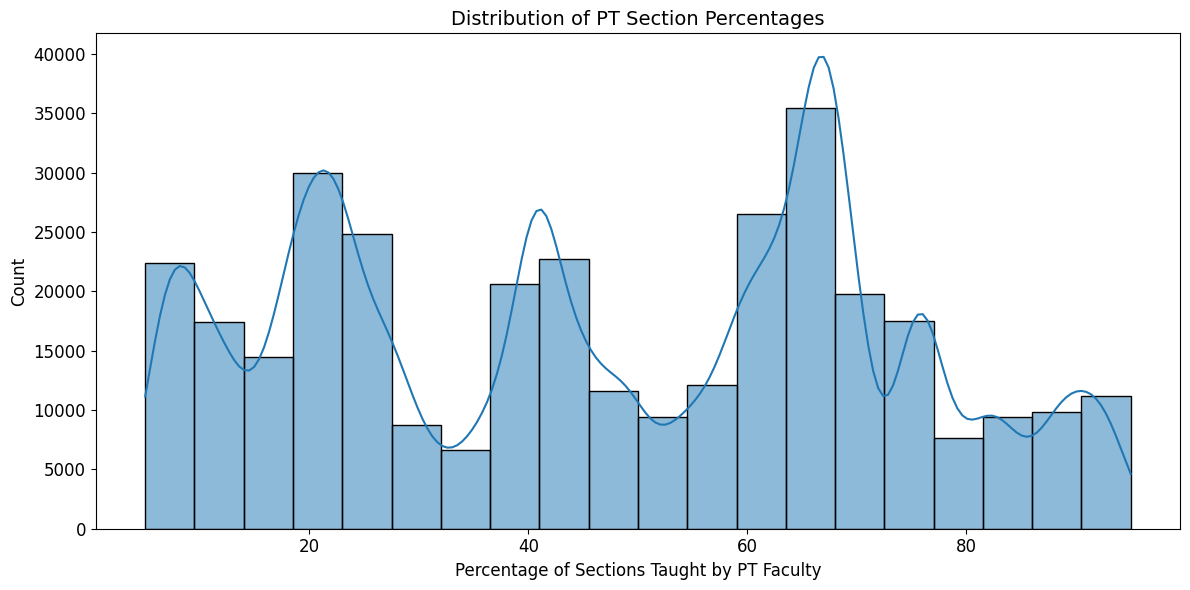

In [36]:
if freshmen_data:
  summary_data = display_metrics(data)
else:
  summary_data = display_metrics(data)

summary_data

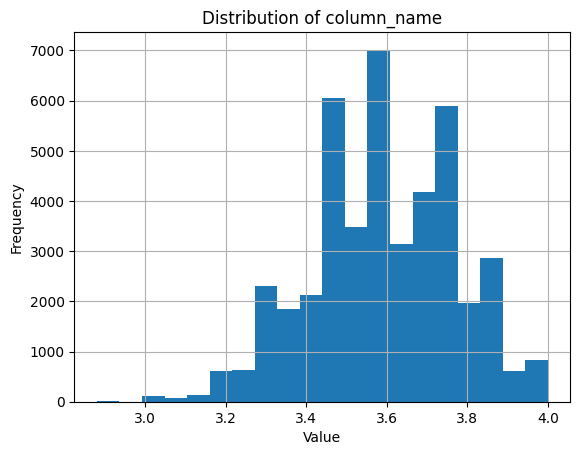

In [ ]:
  # Assuming df is your DataFrame and 'column_name' is the column you want to analyze
  data['HSGPA'].hist(bins=20)  # Adjust bins as needed
  plt.title('Distribution of column_name')
  plt.xlabel('Value')
  plt.ylabel('Frequency')
  plt.show()

## Analysis: Grade Distributions Across FT/PT Instructors (Multiple Courses)


In [2]:
 import seaborn as sns
import matplotlib.pyplot as plt



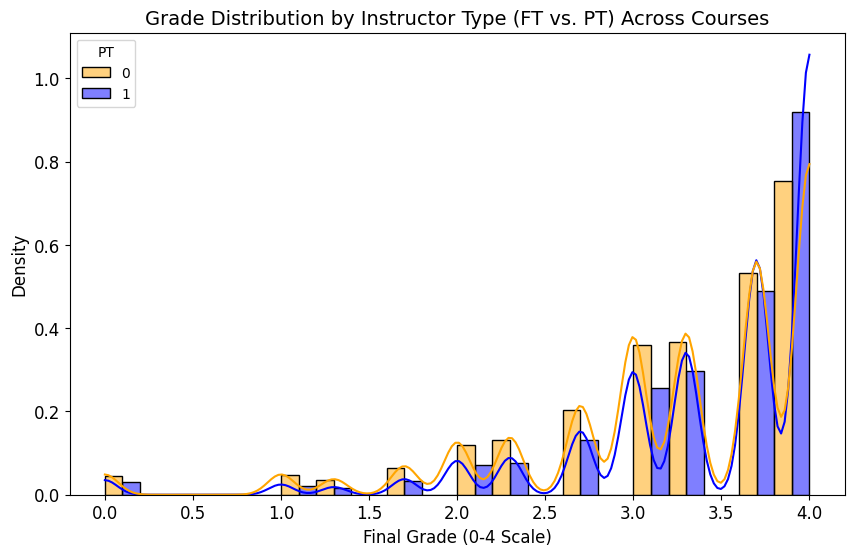

In [38]:
plt.figure(figsize=(10,6))
sns.histplot(
    data=data,
    x="GRADE_FINAL",
    hue="PT",
    kde=True,
    bins=20,
    multiple= "dodge",
    palette={0: "orange", 1: "blue"},  # Match this to your expected colors
    stat="density",
    alpha=0.5
)
plt.title("Grade Distribution by Instructor Type (FT vs. PT) Across Courses", fontsize=14)
plt.xlabel("Final Grade (0-4 Scale)",fontsize=12)
plt.ylabel("Density",fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Let the legend be generated automatically












##Analysis: Compare Means of Covariates Across FT/PT Groups
Next, we need to check for systematic differences in covariates (course enrollment, Pell status, race, etc.) between FT and PT instructors.

In [16]:
# Compute mean covariate values for FT and PT instructors
covariates = ['PRE_COVID','ENROLLMENT','HSGPA','FEMALE', 'PELLSTATUS', 'RACE_MINORITY','PCT_PT_SECTION']

mean_pt = data[data["PT"] == 1][covariates].mean()
mean_ft = data[data["PT"] == 0][covariates].mean()

# Combine into a DataFrame for easy comparison
import pandas as pd
mean_comparison = pd.DataFrame({"PT Instructor (Mean)": mean_pt, "FT Instructor (Mean)": mean_ft})
mean_comparison["Difference"] = mean_comparison["PT Instructor (Mean)"] - mean_comparison["FT Instructor (Mean)"]

mean_comparison


,PT Instructor (Mean),FT Instructor (Mean),Difference
PRE_COVID,0.620433,0.567433,0.053000
ENROLLMENT,22.417070,25.373973,-2.956903
HSGPA,3.581639,3.598983,-0.017345
FEMALE,0.578051,0.565665,0.012387
PELLSTATUS,0.143475,0.154310,-0.010835
RACE_MINORITY,0.122751,0.130862,-0.008111
PCT_PT_SECTION,68.738794,47.736150,21.002644


# Analysis: Statistical Tests for Significant Differences
Now, we formally test whether these covariate differences are statistically significant using t-tests.

In [ ]:
import scipy.stats as stats

# Perform t-tests for differences between FT and PT groups
for cov in covariates:
    t_stat, p_value = stats.ttest_ind(data[data["PT"] == 1][cov], data[data["PT"] == 0][cov])
    print(f"{cov} - t-test p-value: {p_value:.4f}")


PRE_COVID - t-test p-value: 0.0000
ENROLLMENT - t-test p-value: 0.0000
HSGPA - t-test p-value: 0.0000
FEMALE - t-test p-value: 0.3397
PELLSTATUS - t-test p-value: 0.0029
RACE_MINORITY - t-test p-value: 0.0019
PCT_PT_SECTION - t-test p-value: 0.0000


## Analysis: Run a Linear Regression Controlling for covariates

In [ ]:
import statsmodels.formula.api as smf


if freshmen_data:
  model = smf.ols('GRADE_FINAL ~ PT + PCT_PT_SECTION + PRE_COVID + HSGPA + FEMALE + PELLSTATUS + RACE_MINORITY', data=data).fit()
else:
  model = smf.ols('GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + AGE + HSGPA + C(CLASS) + FEMALE + PELLSTATUS + RACE_MINORITY', data=data).fit()


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            GRADE_FINAL   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     5086.
Date:                Tue, 01 Apr 2025   Prob (F-statistic):               0.00
Time:                        01:00:15   Log-Likelihood:            -3.8329e+05
No. Observations:              338251   AIC:                         7.666e+05
Df Residuals:                  338238   BIC:                         7.668e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5437      0.050    -10.

## Analysis: Run a Linear Regression with clustered SE



In [ ]:
import statsmodels.formula.api as smf

# OLS with clustered standard errors
if freshmen_data:
  h_model = smf.ols("GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + HSGPA + FEMALE + PELLSTATUS + RACE_MINORITY ", data=data).fit(cov_type='cluster', cov_kwds={'groups': data['COURSE_SECTION']})
else:
  h_model = smf.ols('GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + AGE + C(CLASS) + HSGPA + FEMALE + PELLSTATUS + RACE_MINORITY', data=data).fit(cov_type='cluster', cov_kwds={'groups': data['COURSE_SECTION']})
# Display results
print(h_model.summary())


                            OLS Regression Results                            
Dep. Variable:            GRADE_FINAL   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     434.0
Date:                Mon, 31 Mar 2025   Prob (F-statistic):               0.00
Time:                        20:42:53   Log-Likelihood:                -59374.
No. Observations:               48138   AIC:                         1.188e+05
Df Residuals:                   48129   BIC:                         1.188e+05
Df Model:                           8                                         
Covariance Type:              cluster                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.1994      0.150    -21.

## Analysis: Check for collinearity

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
if freshmen_data:
  X = data[['PT', 'PRE_COVID', 'HSGPA', 'FEMALE', 'PELLSTATUS', 'RACE_MINORITY', 'PCT_PT_SECTION']]
else:
  X = data[['PT', 'PRE_COVID', 'ENROLLMENT', 'HSGPA', 'FEMALE', 'AGE', 'PELLSTATUS', 'RACE_MINORITY', 'PCT_PT_SECTION']]

X = sm.add_constant(X)

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

         Variable         VIF
0           const  479.652155
1              PT    1.290301
2       PRE_COVID    1.070674
3           HSGPA    1.137060
4          FEMALE    1.059846
5      PELLSTATUS    1.049609
6   RACE_MINORITY    1.052380
7  PCT_PT_SECTION    1.295020


## Analysis: Run a hierarchical linear regression

Note: This was a frist try using a frequentist approach.  A Bayesian approach was later sued (in a different notebook)


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
#data1=data.sample(frac=0.1, replace=False, random_state=1)

# Basic random intercepts model
if freshmen_data:
  formula = "GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + HSGPA + FEMALE + PELLSTATUS + RACE_MINORITY"
else:
  formula = "GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + AGE + HSGPA + C(CLASS) + FEMALE + PELLSTATUS + RACE_MINORITY"
mixed_model = sm.MixedLM.from_formula(
     formula=formula,
     groups=data["COURSE"],
    re_formula="~PT",
    data=data
)

mixed_results = mixed_model.fit(method='lbfgs') #cg
print(mixed_results.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GRADE_FINAL 
No. Observations: 338251  Method:             REML        
No. Groups:       480     Scale:              0.4975      
Min. group size:  4       Log-Likelihood:     -363250.0779
Max. group size:  14385   Converged:          Yes         
Mean group size:  704.7                                   
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept      -0.583    0.053 -10.950 0.000 -0.687 -0.479
C(CLASS)[T.JR]  0.275    0.006  49.988 0.000  0.264  0.286
C(CLASS)[T.SO]  0.180    0.004  47.226 0.000  0.173  0.188
C(CLASS)[T.SR]  0.375    0.007  52.871 0.000  0.361  0.389
PT              0.164    0.012  13.183 0.000  0.140  0.189
PCT_PT_SECTION  0.000    0.000   1.049 0.294 -0.000  0.001
ENROLLMENT      0.001    0.000   6.150 0.000  0.000  0.001
PRE_COVI

In [2]:
pt_fixed = mixed_results.fe_params["PT"]  # global fixed effect for PT

random_effects = mixed_results.random_effects

random_df = pd.DataFrame.from_dict(random_effects, orient='index')


if "PT" in random_df.columns:
    pt_slopes = random_df["PT"]
else:
    pt_slopes = random_df.iloc[:, 1]

pt_total = pt_fixed + pt_slopes

random_df["Total_PT_Effect"] = pt_fixed + random_df["PT"]

top_total = random_df.sort_values(by="Total_PT_Effect", ascending=False)
print(top_total.head(10))
print(top_total.tail(10))


plt.figure(figsize=(10, 5))
sns.histplot(pt_total, bins=30, kde=True)
plt.axvline(pt_fixed, color="blue", linestyle="--", label="Fixed Effect of PT")
plt.title("Estimated Total Effect of PT (Fixed + Course-Level Random Slopes)",fontsize=14)
plt.xlabel("Total Effect of PT on Grade (per Course)",fontsize=12)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


## Analysis: Build Causal Model (Linear)

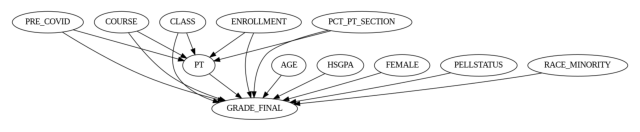

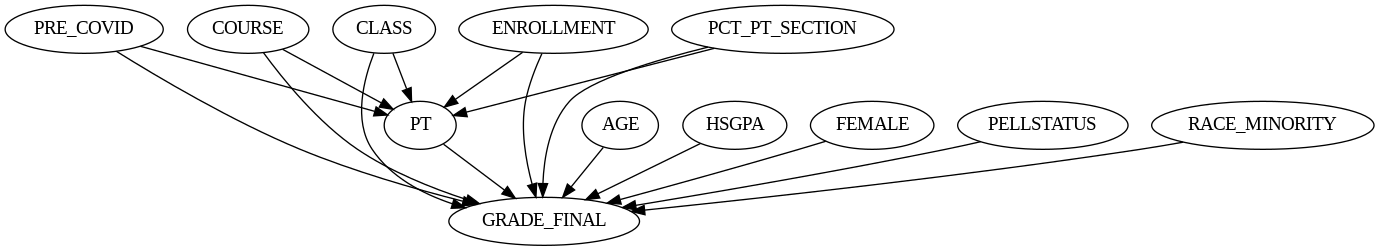

In [89]:
import dowhy
from dowhy import CausalModel
import numpy as np
import pandas as pd

data_clean = data.drop(['COURSE_SECTION'],axis=1).copy()

# Specify the causal graph using DOT notation
if freshmen_data:
  dot_graph = '''digraph {
    PT -> GRADE_FINAL;
    PRE_COVID -> PT;
    PRE_COVID -> GRADE_FINAL;
    COURSE -> PT;
    COURSE -> GRADE_FINAL;
    ENROLLMENT -> GRADE_FINAL;
    ENROLLMENT -> PT;
    PCT_PT_SECTION -> PT;
    PCT_PT_SECTION -> GRADE_FINAL;
    HSGPA -> GRADE_FINAL;
    FEMALE -> GRADE_FINAL;
    PELLSTATUS -> GRADE_FINAL;
    RACE_MINORITY -> GRADE_FINAL;
  }'''
else:
  dot_graph = '''digraph {
    PT -> GRADE_FINAL;
    PRE_COVID -> PT;
    PRE_COVID -> GRADE_FINAL;
    COURSE -> PT;
    COURSE -> GRADE_FINAL;
    CLASS -> PT;
    CLASS -> GRADE_FINAL;
    ENROLLMENT -> GRADE_FINAL;
    ENROLLMENT -> PT;
    PCT_PT_SECTION -> PT;
    PCT_PT_SECTION -> GRADE_FINAL;
    AGE -> GRADE_FINAL;
    HSGPA -> GRADE_FINAL;
    FEMALE -> GRADE_FINAL;
    PELLSTATUS -> GRADE_FINAL;
    RACE_MINORITY -> GRADE_FINAL;
  }'''

# Create the causal model
model = CausalModel(
    data=data_clean,
    treatment='PT',
    outcome='GRADE_FINAL',
    graph=dot_graph
)

model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))


In [90]:
# Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=False)

# Estimate the effect using backdoor adjustment
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True
)

print("Causal Estimate:", estimate)


Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                   
─────(E[GRADE_FINAL|CLASS,PRE_COVID,PCT_PT_SECTION,COURSE,ENROLLMENT])
d[PT]                                                                 
Estimand assumption 1, Unconfoundedness: If U→{PT} and U→GRADE_FINAL then P(GRADE_FINAL|PT,CLASS,PRE_COVID,PCT_PT_SECTION,COURSE,ENROLLMENT,U) = P(GRADE_FINAL|PT,CLASS,PRE_COVID,PCT_PT_SECTION,COURSE,ENROLLMENT)

## Realized estimand
b: GRADE_FINAL~PT+CLASS+PRE_COVID+PCT_PT_SECTION+COURSE+ENROLLMENT+PT*HSGPA+PT*PELLSTATUS+PT*AGE+PT*RACE_MINORITY+PT*FEMALE
Target units: 

## Estimate
Mean value: 0.19798400098671864
p-value: [0.]
### Conditional Estimates
__categorical__HSGPA  __categorical__PELLSTATUS  __categorical__AGE  __categorical__RACE_MINORITY  __categorical__FEMALE
(0.999, 3.4]          (-0.001, 1.0

### Perform refutation tests

In [ ]:
# Perform refutation tests
refutation_results = []
refutation_methods = [
    "random_common_cause",
    "data_subset_refuter",
    "bootstrap_refuter",
]

for method in refutation_methods:
    refutation = model.refute_estimate(
        identified_estimand,
        estimate,
        method_name=method
    )
    refutation_results.append(refutation)
    print(f"Refutation using {method}:", refutation)

Refutation using random_common_cause: Refute: Add a random common cause
Estimated effect:0.19876219160576847
New effect:0.19876219616874194
p value:1.0

Refutation using data_subset_refuter: Refute: Use a subset of data
Estimated effect:0.19876219160576847
New effect:0.19875409205397282
p value:0.92

Refutation using bootstrap_refuter: Refute: Bootstrap Sample Dataset
Estimated effect:0.19876219160576847
New effect:0.19879904180916103
p value:1.0



### Estimate CATE


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CATE for Q1 (HSGPA: 1.0 – 3.4): 0.2940
CATE for Q2 (HSGPA: 3.4 – 3.52): 0.2361
CATE for Q3 (HSGPA: 3.52 – 3.64): 0.1852
CATE for Q4 (HSGPA: 3.64 – 3.72): 0.1581
CATE for Q5 (HSGPA: 3.72 – 4.0): 0.1170
CATE for Female: 0.1883
CATE for Male: 0.2264
CATE for Minority: 0.2259
CATE for Non-Minority: 0.2005
CATE for Pell-Eligible: 0.2261
CATE for Non-Pell: 0.2000
CATE for CLASS FR: 0.2164
CATE for CLASS SO: 0.1866
CATE for CLASS JR: 0.2121
CATE for CLASS SR: 0.1967


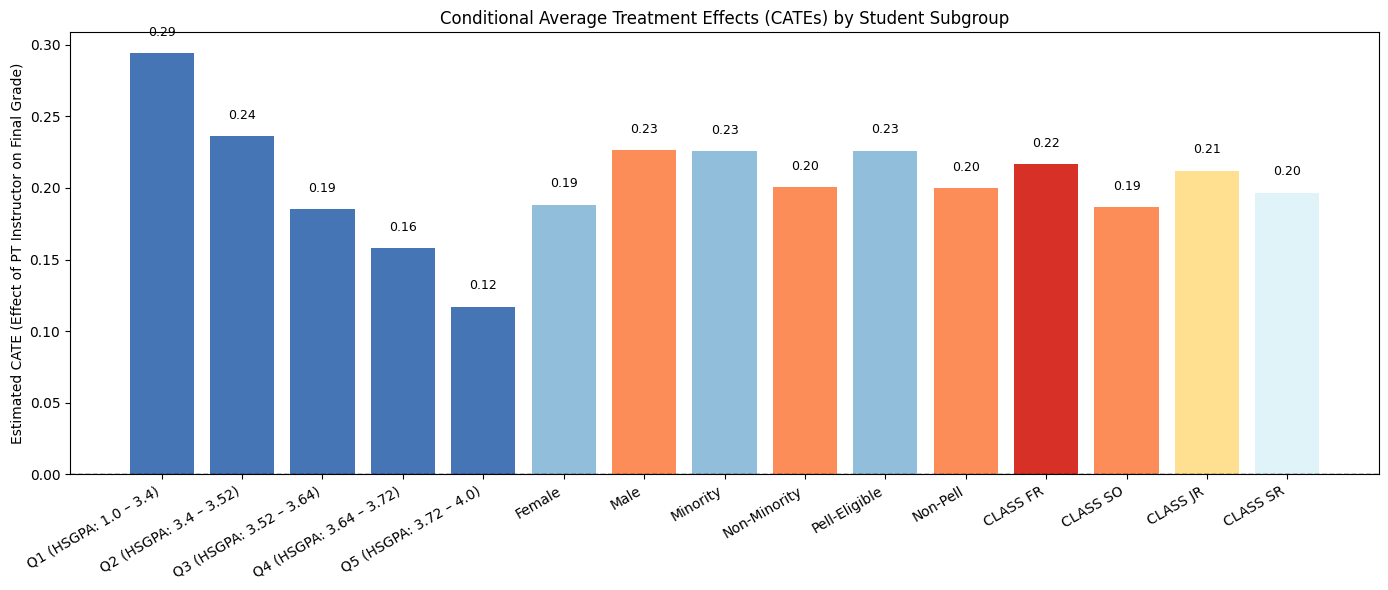

In [101]:
if freshmen_data:
  print ("estimate CATE using DML")
else:
  estimate_cate_all_students_linear(data)


## Analysis: Build Causal Model (Double ML)

In [ ]:
from dowhy import CausalModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LogisticRegressionCV

# Prepare your data (assuming 'data' is your cleaned dataframe)
# Make sure to handle any missing values
data_clean = data.drop(['COURSE_SECTION'],axis=1).copy()

# Define covariates, treatment, and outcome
if freshmen_data:
  covariates = ["ENROLLMENT","PRE_COVID", "PCT_PT_SECTION", "FEMALE", "HSGPA", "RACE_MINORITY", "PELLSTATUS"]
else:
  covariates = ["ENROLLMENT","PRE_COVID", "PCT_PT_SECTION", "FEMALE","AGE", "CLASS", "HSGPA", "RACE_MINORITY", "PELLSTATUS"]
treatment = "PT"
outcome = "GRADE_FINAL"

# One-hot encode categorical variables (e.g., COURSE)
#data_encoded = pd.get_dummies(data_clean[covariates + [treatment, outcome]], drop_first=False)


# New version. Let doWhy deal with encoding
if freshmen_data:
    covariates = ["ENROLLMENT", "PRE_COVID", "PCT_PT_SECTION", "FEMALE",
                 "HSGPA", "RACE_MINORITY", "PELLSTATUS"]
    # Create DOT graph for freshmen data
    dot_graph = '''digraph {
        PT -> GRADE_FINAL;
        PRE_COVID -> PT;
        PRE_COVID -> GRADE_FINAL;
        ENROLLMENT -> GRADE_FINAL;
        ENROLLMENT -> PT;
        PCT_PT_SECTION -> PT;
        PCT_PT_SECTION -> GRADE_FINAL;
        HSGPA -> GRADE_FINAL;
        FEMALE -> GRADE_FINAL;
        PELLSTATUS -> GRADE_FINAL;
        RACE_MINORITY -> GRADE_FINAL;
    }'''
else:
    covariates = ["ENROLLMENT", "PRE_COVID", "PCT_PT_SECTION", "FEMALE", "AGE",
                  "CLASS", "HSGPA", "RACE_MINORITY", "PELLSTATUS"]
    # Create DOT graph for non-freshmen data (including CLASS as confounder)
    dot_graph = '''digraph {
        PT -> GRADE_FINAL;
        PRE_COVID -> PT;
        PRE_COVID -> GRADE_FINAL;
        ENROLLMENT -> GRADE_FINAL;
        ENROLLMENT -> PT;
        PCT_PT_SECTION -> PT;
        PCT_PT_SECTION -> GRADE_FINAL;
        AGE -> GRADE_FINAL;
        HSGPA -> GRADE_FINAL;
        FEMALE -> GRADE_FINAL;
        PELLSTATUS -> GRADE_FINAL;
        RACE_MINORITY -> GRADE_FINAL;
        CLASS -> PT;
        CLASS -> GRADE_FINAL;
    }'''

# *** Key change: Pass the original data (before one-hot encoding) to CausalModel ***
model = CausalModel(
    data=data_clean[covariates + [treatment, outcome]],
    treatment=treatment,
    outcome=outcome,
    graph=dot_graph
)

In [95]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338251 entries, 0 to 491266
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   PT              338251 non-null  int64   
 1   COURSE          338251 non-null  object  
 2   PRE_COVID       338251 non-null  int64   
 3   ENROLLMENT      338251 non-null  int64   
 4   PCT_PT_SECTION  338251 non-null  float64 
 5   AGE             338251 non-null  int64   
 6   CLASS           338251 non-null  object  
 7   HSGPA           338251 non-null  float64 
 8   FEMALE          338251 non-null  int64   
 9   PELLSTATUS      338251 non-null  int64   
 10  RACE_MINORITY   338251 non-null  int64   
 11  GRADE_FINAL     338251 non-null  float64 
 12  HSGPA_BIN       338251 non-null  category
dtypes: category(1), float64(3), int64(7), object(2)
memory usage: 33.9+ MB


In [96]:
# Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=False)
print(identified_estimand)

# Estimate the effect using DoWhy's API with EconML's Double ML

# if using Random Forest
optimized_rf = RandomForestRegressor(
    # Speed improvements
    n_estimators=100,       # Reduced from default 100-200
    max_depth=10,           # Limit tree depth
    min_samples_leaf=20,    # Require more samples per leaf
    min_samples_split=20,   # Require more samples to split
    max_features='sqrt',    # Use sqrt(n_features) for splits

    # Reduce overfitting (helps with refutation tests)
    bootstrap=True,         # Use bootstrapping
    oob_score=True,         # Out-of-bag scoring
    max_samples=0.7,        # Use 70% of samples per tree

    # Performance
    n_jobs=-1,              # Use all processors
    random_state=42         # Reproducibility
)



causal_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.econml.dml.LinearDML",
                                        control_value=0,  # FT Instructor
                                        treatment_value=1,  # PT Instructor
                                        confidence_intervals=True,
                                        method_params={"init_params": {
                                                                       'model_y':  LassoCV(),
                                                                       #'model_y': optimized_rf,
                                                                       'model_t': LogisticRegressionCV(solver="saga", max_iter=5000),
                                                                       'discrete_treatment': True,
                                                                       'random_state': 42
                                                                      },
                                                       "fit_params": {}
                                                      }
                                      )

print(f"Estimated ATE (DoWhy + Double ML): {causal_estimate.value}")

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                            
─────(E[GRADE_FINAL|CLASS,PRE_COVID,PCT_PT_SECTION,ENROLLMENT])
d[PT]                                                          
Estimand assumption 1, Unconfoundedness: If U→{PT} and U→GRADE_FINAL then P(GRADE_FINAL|PT,CLASS,PRE_COVID,PCT_PT_SECTION,ENROLLMENT,U) = P(GRADE_FINAL|PT,CLASS,PRE_COVID,PCT_PT_SECTION,ENROLLMENT)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Estimated ATE (DoWhy + Double ML): 0.20627216781839736


### Perform refutation tests

In [ ]:
# Perform refutation tests
refutation_results = []
refutation_methods = [
    "random_common_cause",
    "data_subset_refuter",
    "bootstrap_refuter",
]

for method in refutation_methods:
    refutation = model.refute_estimate(
        identified_estimand,
        causal_estimate,
        method_name=method
    )
    refutation_results.append(refutation)
    print(f"Refutation using {method}:", refutation)

### Analysis: Estimate CATE

CATE for HSGPA: Q1: 0.2904
CATE for HSGPA: Q2: 0.2341
CATE for HSGPA: Q3: 0.1955
CATE for HSGPA: Q4: 0.1634
CATE for HSGPA: Q5: 0.1215
CATE for Female: 0.1898
CATE for Male: 0.2293
CATE for Minority: 0.2286
CATE for Non-Minority: 0.2031
CATE for Pell-Eligible: 0.2304
CATE for Non-Pell: 0.2023
CATE for FR: 0.1985
CATE for SO: 0.2025
CATE for JR: 0.2154
CATE for SR: 0.2212


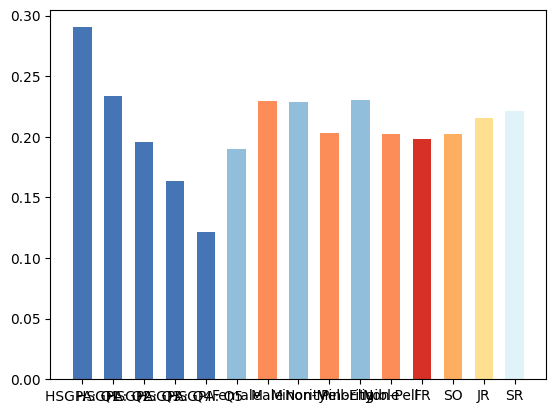

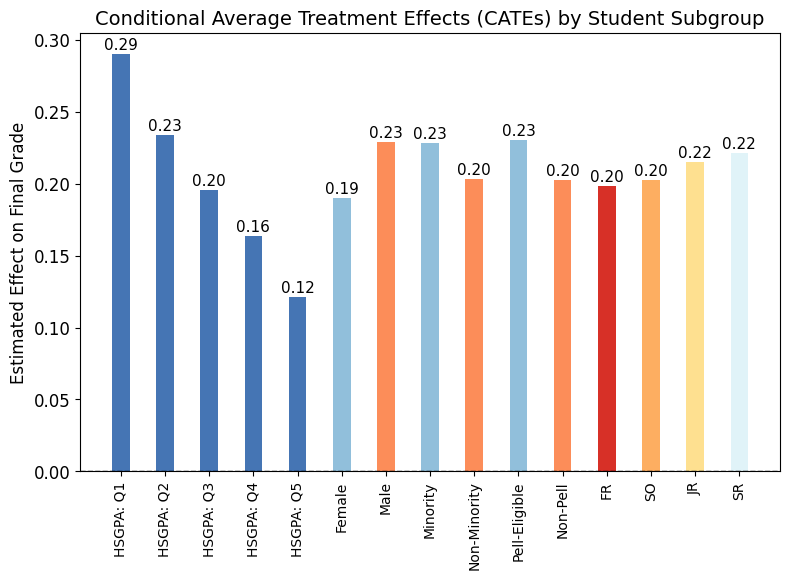

In [104]:
if freshmen_data:
  estimate_cate_freshmen_DML(data_encoded)
else:
  estimate_cate_freshmen_DML_all(data_encoded,causal_estimate)

## Analyis: Run Quantile Regression at 25th and 75th Percentiles

In [14]:
import statsmodels.formula.api as smf

# 25th percentile (weaker students)
if freshmen_data:
  model_q25 = smf.quantreg('GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + HSGPA + FEMALE + PELLSTATUS + RACE_MINORITY', data=data).fit(q=0.25, max_iter=5000,cov_type='cluster', cov_kwds={'groups': data['COURSE']})
else:
  model_q25 = smf.quantreg('GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + AGE + HSGPA + C(CLASS) + FEMALE + PELLSTATUS + RACE_MINORITY', data=data).fit(q=0.25, max_iter=5000,cov_type='cluster', cov_kwds={'groups': data['COURSE']})
print("25th Percentile Results:")
print(model_q25.summary())

# 50th percentile (stronger students)
if freshmen_data:
  model_q50 = smf.quantreg('GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + HSGPA + FEMALE + PELLSTATUS + RACE_MINORITY', data=data).fit(q=0.50, max_iter=5000,cov_type='cluster', cov_kwds={'groups': data['COURSE']})
else:
  model_q50 = smf.quantreg('GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + AGE + HSGPA + C(CLASS) + FEMALE + PELLSTATUS + RACE_MINORITY', data=data).fit(q=0.50, max_iter=5000,cov_type='cluster', cov_kwds={'groups': data['COURSE']})
print("\n50th Percentile Results:")
print(model_q50.summary())

# 75th percentile (stronger students)
if freshmen_data:
  model_q75 = smf.quantreg('GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + HSGPA + FEMALE + PELLSTATUS + RACE_MINORITY', data=data).fit(q=0.75, max_iter=5000,cov_type='cluster', cov_kwds={'groups': data['COURSE']})
else:
  model_q75 = smf.quantreg('GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + AGE + HSGPA + C(CLASS) + FEMALE + PELLSTATUS + RACE_MINORITY', data=data).fit(q=0.75, max_iter=5000,cov_type='cluster', cov_kwds={'groups': data['COURSE']})
print("\n75th Percentile Results:")
print(model_q75.summary())



25th Percentile Results:
                         QuantReg Regression Results                          
Dep. Variable:            GRADE_FINAL   Pseudo R-squared:               0.1182
Model:                       QuantReg   Bandwidth:                     0.08091
Method:                 Least Squares   Sparsity:                        2.859
Date:                Sun, 27 Apr 2025   No. Observations:                48138
Time:                        00:42:07   Df Residuals:                    48129
                                        Df Model:                            8
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.7069      0.127    -44.772      0.000      -5.957      -5.457
PT                 0.2909      0.013     22.146      0.000       0.265       0.317
PCT_PT_SECTION     0.0045      0.000     14.822      0.000       0.004       0.005
ENROLLM

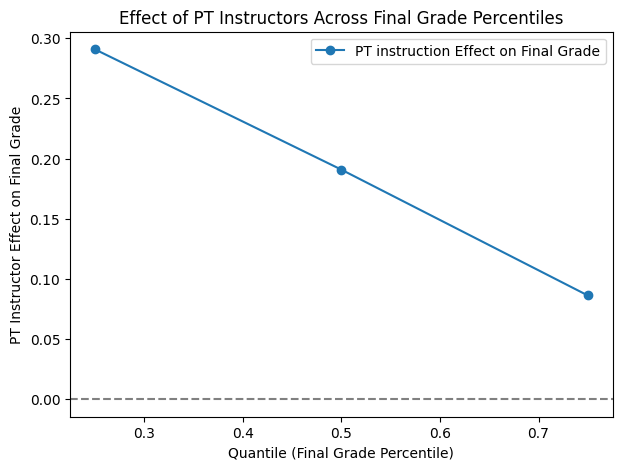

In [17]:
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

quantiles = [0.25, 0.50, 0.75]
ft_effects = []

for q in quantiles:
    if freshmen_data:
      model_q = smf.quantreg('GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + HSGPA + FEMALE + PELLSTATUS + RACE_MINORITY', data=data).fit(q=q, max_iter=5000,cov_type='cluster', cov_kwds={'groups': data['COURSE']})
    else:
      model_q = smf.quantreg('GRADE_FINAL ~ PT + PCT_PT_SECTION + ENROLLMENT + PRE_COVID + AGE + HSGPA + C(CLASS) + FEMALE + PELLSTATUS + RACE_MINORITY', data=data).fit(q=q, max_iter=5000,cov_type='cluster', cov_kwds={'groups': data['COURSE']})
    ft_effects.append(model_q.params["PT"])

plt.figure(figsize=(7,5))
plt.plot(quantiles, ft_effects, marker='o', linestyle='-', label="PT instruction Effect on Final Grade")
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("Quantile (Final Grade Percentile)")
plt.ylabel("PT Instructor Effect on Final Grade")
plt.title("Effect of PT Instructors Across Final Grade Percentiles")
plt.legend()
plt.show()

### Analysis: Run Quantile Regression at 25th 50th and  75th Percentiles using EconML

In [2]:
from econml.iv.dml import DMLIV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegressionCV
import pandas as pd
import numpy as np

# Define covariates
covariates = ["ENROLLMENT", "RACE_MINORITY"]
X = pd.get_dummies(data[["ENROLLMENT", "RACE_MINORITY", "COURSE"]], drop_first=True)  # One-hot encode COURSE

# Define treatment & outcome
T = data["PT"]  # Treatment: Full-time instructor (Binary)
Y = data["GRADE_FINAL"]  # Outcome: Final Grade

# Initialize DMLIV model with correct classifier for binary treatment
dmliv = DMLIV(model_y_xw=RandomForestRegressor(),  # Outcome model
              model_t_xw=LogisticRegressionCV(),   # Treatment model (Binary classifier)
              discrete_treatment=True,
              random_state=42)

# Fit the model
dmliv.fit(Y, T, X=X, Z=None)  # No instrument (Z), using confounders X

# Estimate effects at 25th and 75th quantiles
quantiles = [0.25, 0.75]
ate_q25 = np.quantile(dmliv.effect(X), 0.25)
ate_q75 = np.quantile(dmliv.effect(X), 0.75)

print(f"Estimated ATE at 25th Percentile (DMLIV-Q, Fixed Model): {ate_q25}")
print(f"Estimated ATE at 75th Percentile (DMLIV-Q, Fixed Model): {ate_q75}")


## ==============================The end
